In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取Excel文件
excel_file = 'trainset.xlsx'

# 读取四个表格
df11 = pd.read_excel(excel_file, sheet_name='材料1')
df2 = pd.read_excel(excel_file, sheet_name='材料2')
df3 = pd.read_excel(excel_file, sheet_name='材料3')
df4 = pd.read_excel(excel_file, sheet_name='材料4')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002E64D2A0CD0>>
Traceback (most recent call last):
  File "c:\minconda\envs\torch_env\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [2]:
df = pd.concat([df11, df2, df3, df4])
# 获取1024个磁通密度采样点
df1 = df.iloc[:, -1024:]

In [3]:
sin_row = df['励磁波形']== '正弦波'
tri_row = df['励磁波形']== '三角波'
tra_row = df['励磁波形']== '梯形波'

print('正弦波行数：',sum(sin_row))
print('三角波行数：',sum(tri_row))
print('梯形波行数：',sum(tra_row))

正弦波行数： 4054
三角波行数： 4948
梯形波行数： 3398


In [4]:
# 归一化
df1_T = df1.T
df1_normalized = (df1_T-df1_T.min()) / (df1_T.max()-df1_T.min())
df1_normalized = df1_normalized.T

In [13]:
# draw a plot
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
for i in range(1070,1100):
    df1.iloc[i,:].plot()
plt.show()

In [ ]:
for i in range(2800,3000):
    df1.iloc[i,:].plot()
plt.show()

In [5]:
df1_normalized_sum = df1_normalized.sum(axis=1)
df1_normalized_sum = pd.DataFrame({"sum":df1_normalized_sum,"label":df['励磁波形']})

# 标签替换
size_mapping = {'正弦波':1,'三角波':2,'梯形波':3}
df1_normalized_sum['label'] = df1_normalized_sum['label'].map(size_mapping)

In [ ]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the iris dataset

X = np.array(df1_normalized_sum['sum'])
y = np.array(df1_normalized_sum['label'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=5, max_depth=2, max_features=2)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
acc = sum(y_pred == y_test)/len(y_test)

# Print the accuracy score
print("Accuracy:",acc)

In [6]:
# 计算傅里叶变换
df1_normalized = np.array(df1_normalized)
n = 12400 #样本数
xf = np.zeros((n, 1024))
for i in range(n):
    df1_n = df1_normalized[i,:]
    xfft = np.fft.fft(df1_n)
    xfft = xfft.reshape(1,1024)
    xfft[0,0] = 0.5*xfft[0,0]
    xf[i,:] = np.array(np.abs(xfft)/1024*2)
# label = np.array(df1_normalized_sum['label'])
xf1 = np.hstack((xf[:,:5],xf[:,-5:]))


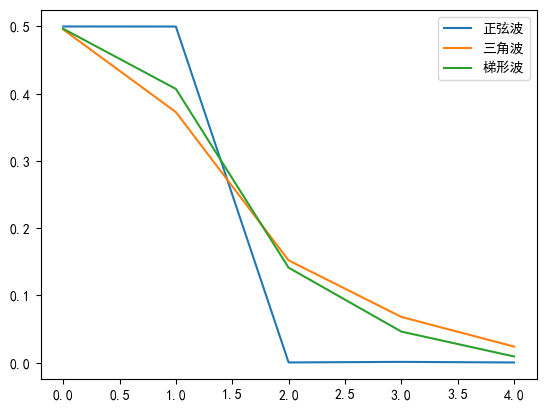

In [14]:
# 绘制频谱图
plt.plot(xf[2,0:5],label='正弦波')
plt.plot(xf[2000,0:5],label='三角波')
plt.plot(xf[3000,0:5],label='梯形波')
# plt.legend()
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
# plt.title('Triangle Wave Spectrum')
plt.legend()
plt.show()

[1 1 1 ... 0 0 0]


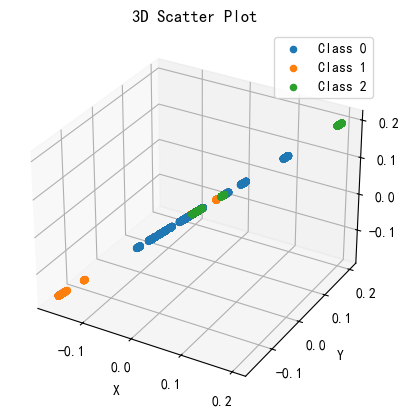

In [8]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# 使用Hierarchical聚类算法
hclust = AgglomerativeClustering(n_clusters=3)
hclust.fit(xf1)

# 获取聚类结果
labels = hclust.labels_
print(labels)

# 使用PCA将数据降维到3维
pca = PCA(n_components=3)
X_pca = pca.fit_transform(xf1)

# 创建一个三维散点图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 根据标签绘制散点图
for i in range(3):
    idx = labels == i
    ax.scatter(X_pca[idx], X_pca[idx], X_pca[idx], label=f'Class {i}')

# 添加标题和标签
ax.set_title('3D Scatter Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 添加图例
ax.legend()

# 显示图
plt.show()

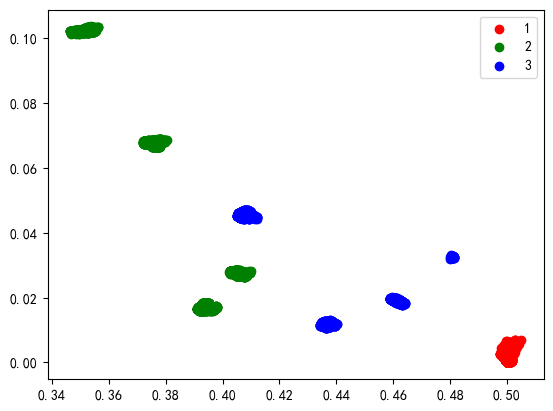

In [9]:
# 使用 np.unique 函数来获取唯一的标签值
label = np.array(df1_normalized_sum['label'])
unique_labels = np.unique(label)

# 定义颜色列表
colors = ['red', 'green', 'blue']

# 使用 plt.scatter 函数来绘制散点图
for i, labels in enumerate(unique_labels):
    label_mask = label == labels
    plt.scatter(xf1[label_mask, 1], xf1[label_mask, 3], label=labels, c=colors[i % len(colors)])

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = np.array(xf1[:,0:5])
y = label.reshape(12400,1)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建一个SVM模型
clf = SVC(kernel='rbf', C=10)  # kernel表示核函数，C表示惩罚项系数

# 训练模型
clf.fit(X_train, y_train)

# 预测测试集
y_pred = clf.predict(X_test)
y_pred = y_pred.reshape(len(y_pred),1)
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


c:\Users\tony\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
ourtest = pd.read_excel('ourtest.xlsx')
X_ot = ourtest.iloc[:,-1025:-1]
# 标准化
X_otT = X_ot.T
X_otT_normalized = (X_otT-X_otT.min()) / (X_otT.max()-X_otT.min())
X_ot_normalized = np.array(X_otT_normalized.T)

# 快速傅里叶
n = 80 #样本数
xf_ot = np.zeros((n, 1024))
for i in range(n):
    df1_n = X_ot_normalized[i,:]
    xfft = np.fft.fft(df1_n)
    xfft = xfft.reshape(1,1024)
    xfft[0,0] = 0.5*xfft[0,0]
    xf_ot[i,:] = np.array(np.abs(xfft)/1024*2)
X_ot1 = np.array(xf_ot[:,0:5])

# 预测
y_pred = clf.predict(X_ot1)
y_ottest = np.array(ourtest.iloc[:,-1])
# 计算准确率
accuracy = accuracy_score(y_ottest, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
mm = 10
# Create a figure with 2 rows and 2 columns
fig, axs = plt.subplots(1, 2)

# Plot something on each subplot
axs[0].plot(X_ot_normalized[mm,:])
xfft = np.fft.fft(X_ot_normalized[mm,:])
axs[1].plot(xfft[0:10])


# Show the plot
plt.show()
# plt.legend()
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
# plt.title('Triangle Wave Spectrum')

In [ ]:
# 绘制频谱图
plt.plot(xf_ot[mm,0:10])

# plt.legend()
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude')
# plt.title('Triangle Wave Spectrum')
plt.show()
print(y_ottest[mm])